In [1]:
import matplotlib.pyplot as plt

SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 24

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

COLORS = {
    'green': '#009e73',
    'blue': '#0072b2',
    'yellow': '#f1e443',
    'orange': '#e69f03',
    'red': '#d55f00',
    'purple': '#cc79a7'
}

In [4]:
import builtins
from collections import defaultdict

DELIMITER = "---"
PAYLOAD_KEY = "textPayload"
TIMESTAMP_KEY = "timestamp"

def process_logs(logs: str):
    times = {}
    request_paths = {}
    get = 0
    post = 0
    with builtins.open(logs, 'r') as f:
        lines = f.readlines()
        for i in range(len(lines)):
            line = lines[i]
            #print(line)
            if PAYLOAD_KEY not in line:
                continue
            if "GET" in line:
                get += 1
            if "POST" in line:
                post += 1
            payload = line.strip()
            while (TIMESTAMP_KEY not in lines[i]):
                i += 1
                if (TIMESTAMP_KEY not in lines[i]):
                    payload += " " + lines[i].strip()
                    #print(f"ADDING TO PAYLOAD {payload}")
                    
            path, request_id = process_payload_simple(payload, times)
            request_paths[request_id] = path
    print(f"GET: {get}")
    print(f"POST: {post}")
    return (times, request_paths)

def process_payload_simple(payload: str, times: dict):
    #print(f"Processing {payload}")
    payload = payload.split("textPayload: ")[1]
    time_for_this_step = float(payload.split(" -- ")[1]) * 1000

    # Remove time
    payload = payload.split(" -- ")[0]
    request_id = payload.split(" ")[0]

    # Remove request ID
    path = payload.split(" ")[1]
    payload = " ".join(payload.split(" ")[2:])

    total_prints = 13 if 'GET' in request_id else 14

    if request_id in times and len(times[request_id]) == total_prints:
        request_id += "A"

    if request_id in times:
        times[request_id][payload] = time_for_this_step
    else:
        times[request_id] = {payload: time_for_this_step}
    
    return (path, request_id)

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import textwrap
from matplotlib.ticker import MaxNLocator

def plot_times(times: dict, name: str, plots_dir: str):
    print(f"------------------ {name} ------------------")
    for k, t_list in times.items():
        print(k, f"| Median: {np.median(np.array(t_list))} ms")
        plt.hist(t_list, bins=10, edgecolor='black')
        title = f"{name} {k}"
        wrapped_title = textwrap.fill(title, 60)  # Wrap after 60 characters
        plt.title(wrapped_title)

        # Use the formatter for the x-axis labels
        ax = plt.gca()
        # ax.xaxis.set_major_formatter(formatter)

        # Set the maximum number of x-axis labels to 10
        ax.xaxis.set_major_locator(MaxNLocator(nbins=10))

        plt.xlabel("Time (ms)")
        key = k.split("(")[0].strip()
        plotname = "-".join(key.split(" << ")[1:])
        plt.savefig(f"{plots_dir}/{name}_{plotname}.png")
        plt.clf()

In [6]:
import os

times, request_paths = process_logs(os.path.join(os.getcwd(), "logs/gcp_logs_15_parallel.txt"))
get_times = defaultdict(list)
post_times = defaultdict(list)
create_auth_times = defaultdict(list)
gets = 0
posts = 0
get_time_set = set()
post_time_set = set()
for key, time_breakdown in times.items():
    if "GET" in key:
        gets += 1
        get_time_set.add(len(time_breakdown.keys()))
        for k, v in time_breakdown.items():
            get_times[k].append(v)
    elif "POST" in key:
        posts += 1
        post_time_set.add(len(time_breakdown.keys()))
        for k, v in time_breakdown.items():
            post_times[k].append(v)
    elif "CREATE_AUTH" in key:
        for k, v in time_breakdown.items():
            create_auth_times[k].append(v)
    else:
        print("Unknown key", key)
print(f"GETS: {gets}")
print(f"POSTS: {posts}")
print(f"GET TIMES: {get_time_set}")
print(f"POST TIMES: {post_time_set}")

plots_dir = os.path.join(os.getcwd(), "plots")
plot_times(get_times, "GET15", plots_dir)
plot_times(post_times, "POST15", plots_dir)

GET: 585
POST: 776
GETS: 45
POSTS: 58
GET TIMES: {13}
POST TIMES: {2, 14}
------------------ GET15 ------------------
skypilot_forward:generic_forward_request << total | Median: 217.1182632446289 ms
skypilot_forward:generic_forward_request << send_gcp_request | Median: 204.61606979370117 ms
skypilot_forward:generic_forward_request << get_headers_with_auth | Median: 0.07343292236328125 ms
skypilot_forward:generic_forward_request << get_new_url | Median: 0.2491474151611328 ms
skypilot_forward:generic_forward_request << check_request_from_policy | Median: 2.9473304748535156 ms
skypilot_forward:generic_forward_request << check_request_from_policy << total (policy check passed, no SA attach) | Median: 2.6144981384277344 ms
skypilot_forward:generic_forward_request << check_request_from_policy << check_request | Median: 0.6377696990966797 ms
skypilot_forward:generic_forward_request << check_request_from_policy << set_authorization_manager | Median: 0.0030994415283203125 ms
skypilot_forward:ge

<Figure size 640x480 with 0 Axes>

In [7]:
import os

times, request_paths = process_logs(os.path.join(os.getcwd(), "logs/gcp_logs_no_concurrency.txt"))
get_times = defaultdict(list)
post_times = defaultdict(list)
create_auth_times = defaultdict(list)
gets = 0
posts = 0
get_time_set = set()
post_time_set = set()
for key, time_breakdown in times.items():
    if "GET" in key:
        gets += 1
        get_time_set.add(len(time_breakdown.keys()))
        for k, v in time_breakdown.items():
            get_times[k].append(v)
    elif "POST" in key:
        posts += 1
        post_time_set.add(len(time_breakdown.keys()))
        for k, v in time_breakdown.items():
            post_times[k].append(v)
    elif "CREATE_AUTH" in key:
        for k, v in time_breakdown.items():
            create_auth_times[k].append(v)
    else:
        print("Unknown key", key)
print(f"GETS: {gets}")
print(f"POSTS: {posts}")
print(f"GET TIMES: {get_time_set}")
print(f"POST TIMES: {post_time_set}")

GET: 650
POST: 700
GETS: 50
POSTS: 50
GET TIMES: {13}
POST TIMES: {14}


In [8]:
unique_paths_post = set()
unique_paths_get = set()
for request, path in request_paths.items():
    if "POST" in request:
        unique_paths_post.add(path)
    elif "GET" in request:
        unique_paths_get.add(path)
    elif "CREATE_AUTH" in request:
        print(path)
print(f"Unique paths POST: {unique_paths_post}")
print(f"Unique paths GET: {unique_paths_get}")

Unique paths POST: {'/compute/v1/projects/sky-identity/zones/us-west1-b/instances'}
Unique paths GET: {'/compute/v1/projects/debian-cloud/global/images/family/debian-10'}


In [46]:
print(f"{times}")
print(f"{request_paths}")

{'POST937': {'skypilot_forward:generic_forward_request << total': 1254.3163299560547, 'skypilot_forward:generic_forward_request << send_gcp_request': 1240.6795024871826, 'skypilot_forward:generic_forward_request << get_json_with_service_account': 0.18310546875, 'skypilot_forward:generic_forward_request << get_headers_with_auth': 0.07939338684082031, 'skypilot_forward:generic_forward_request << get_new_url': 0.22268295288085938, 'skypilot_forward:generic_forward_request << check_request_from_policy': 8.765697479248047, 'skypilot_forward:generic_forward_request << check_request_from_policy << total (policy check passed, w/ SA attach)': 8.587360382080078, 'skypilot_forward:generic_forward_request << check_request_from_policy << check_request': 7.1563720703125, 'skypilot_forward:generic_forward_request << check_request_from_policy << set_authorization_manager': 0.005245208740234375, 'skypilot_forward:generic_forward_request << check_request_from_policy << get_policy': 0.17642974853515625, 

In [47]:
plots_dir = os.path.join(os.getcwd(), "plots")
plot_times(get_times, "GET", plots_dir)
plot_times(post_times, "POST", plots_dir)
plot_times(create_auth_times, "CREATE_AUTH", plots_dir)

------------------ GET ------------------
skypilot_forward:generic_forward_request << total | Median: 218.3293104171753 ms
skypilot_forward:generic_forward_request << send_gcp_request | Median: 211.05480194091797 ms
skypilot_forward:generic_forward_request << get_headers_with_auth | Median: 0.07867813110351562 ms
skypilot_forward:generic_forward_request << get_new_url | Median: 0.23651123046875 ms
skypilot_forward:generic_forward_request << check_request_from_policy | Median: 2.505779266357422 ms
skypilot_forward:generic_forward_request << check_request_from_policy << total (policy check passed, no SA attach) | Median: 2.3125410079956055 ms
skypilot_forward:generic_forward_request << check_request_from_policy << check_request | Median: 0.6272792816162109 ms
skypilot_forward:generic_forward_request << check_request_from_policy << set_authorization_manager | Median: 0.005364418029785156 ms
skypilot_forward:generic_forward_request << check_request_from_policy << get_policy | Median: 0.172

<Figure size 640x480 with 0 Axes>

------------------ GET ------------------
total | Mean: 218.80075931549072 ms, Std. Dev: 16.503598188021954 ms | Median: 218.3293104171753 ms | Max: 258.7018013000488 ms | Min: 178.55215072631836 ms
send_gcp_request | Mean: 211.36394023895264 ms, Std. Dev: 16.633893448324603 ms | Median: 211.05480194091797 ms | Max: 251.93381309509277 ms | Min: 171.86975479125977 ms
get_headers_with_auth | Mean: 0.1034402847290039 ms, Std. Dev: 0.13659837487049806 ms | Median: 0.07867813110351562 ms | Max: 1.0459423065185547 ms | Min: 0.06818771362304688 ms
get_new_url | Mean: 0.25397777557373047 ms, Std. Dev: 0.054430054294879106 ms | Median: 0.23651123046875 ms | Max: 0.4737377166748047 ms | Min: 0.20956993103027344 ms
check_request_from_policy | Mean: 2.6422929763793945 ms, Std. Dev: 0.3072959598116033 ms | Median: 2.505779266357422 ms | Max: 3.454923629760742 ms | Min: 2.310037612915039 ms
check_request_from_policy-total | Mean: 2.4297714233398438 ms, Std. Dev: 0.290917572554415 ms | Median: 2.3125

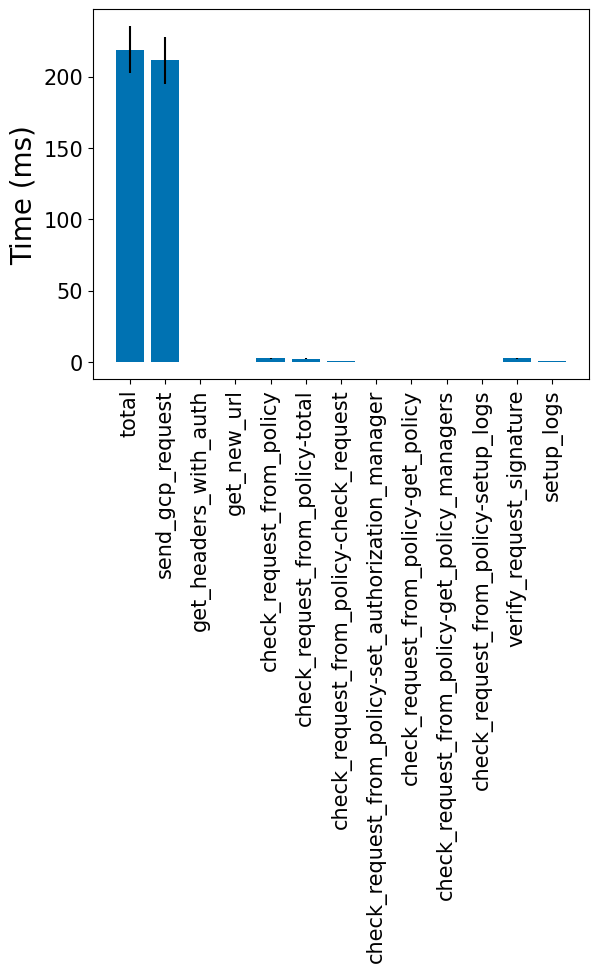

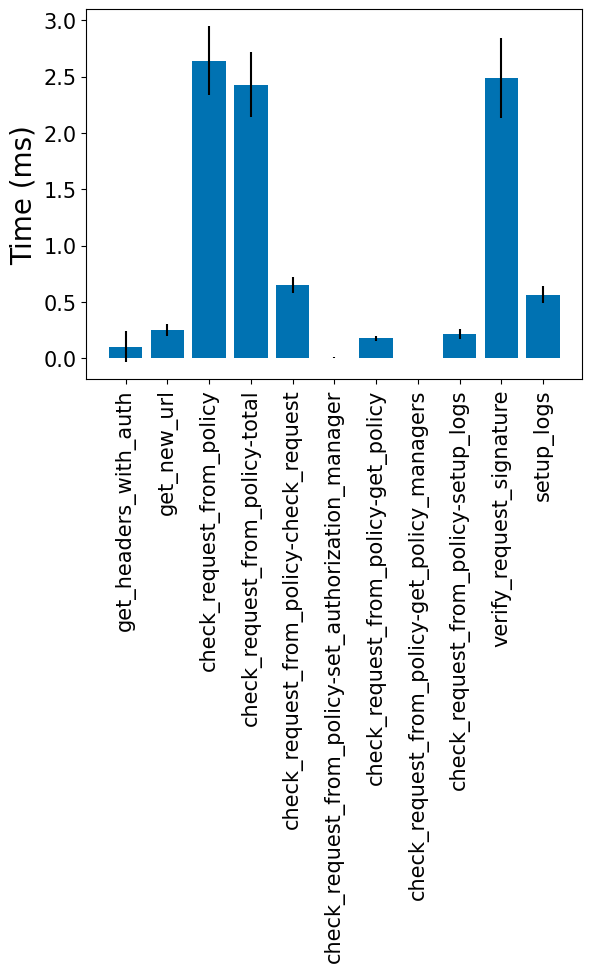

------------------ POST ------------------
total | Mean: 1290.9924840927124 ms, Std. Dev: 172.72251950637363 ms | Median: 1283.8249206542969 ms | Max: 1768.9738273620605 ms | Min: 903.8543701171875 ms
send_gcp_request | Mean: 1276.5782308578491 ms, Std. Dev: 172.81798894910585 ms | Median: 1270.0350284576416 ms | Max: 1755.495309829712 ms | Min: 889.6591663360596 ms
get_json_with_service_account | Mean: 0.21338462829589844 ms, Std. Dev: 0.04572351205679797 ms | Median: 0.19824504852294922 ms | Max: 0.41222572326660156 ms | Min: 0.1800060272216797 ms
get_headers_with_auth | Mean: 0.08122920989990234 ms, Std. Dev: 0.009594889050134912 ms | Median: 0.080108642578125 ms | Max: 0.110626220703125 ms | Min: 0.06628036499023438 ms
get_new_url | Mean: 0.26214122772216797 ms, Std. Dev: 0.055768837358322255 ms | Median: 0.24962425231933594 ms | Max: 0.5033016204833984 ms | Min: 0.20313262939453125 ms
check_request_from_policy | Mean: 9.274063110351562 ms, Std. Dev: 0.8119718699704594 ms | Median:

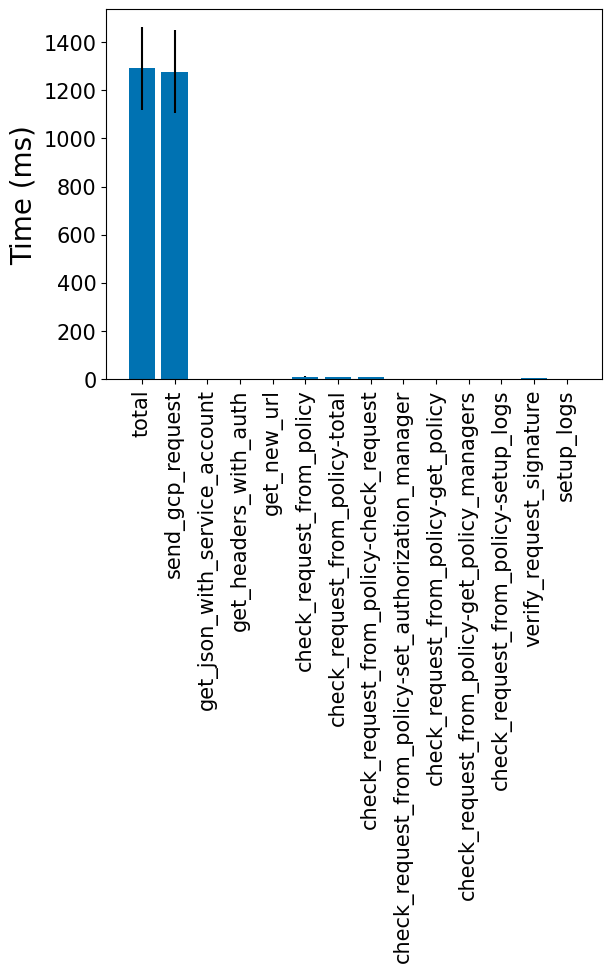

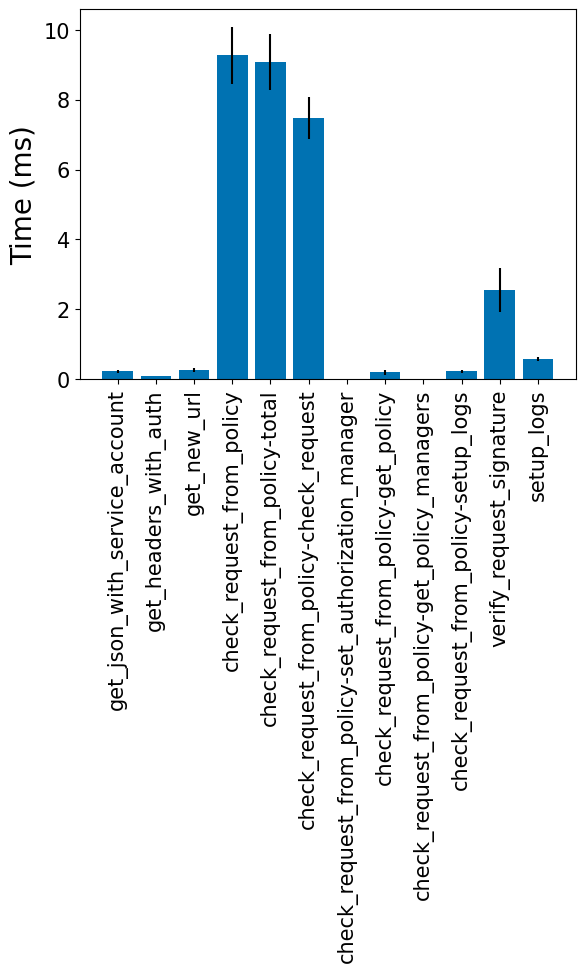

In [10]:
def plot_mean_times(times: dict, name: str):
    print(f"------------------ {name} ------------------")
    all_times = defaultdict(list)
    times_dict = defaultdict(list)
    for req, t_list in times.items():
        if name not in req:
            continue
        times_dict[req] = {}
        for event, time in t_list.items():
            tmp = event.split("(")[0].strip()
            event_name = "-".join(tmp.split(" << ")[1:])
            all_times[event_name].append(time)
            times_dict[req][event_name] = time
    for k, t_list in all_times.items():
        times_array = np.array(t_list)
        print(k, f"| Mean: {np.mean(times_array)} ms, Std. Dev: {np.std(times_array)} ms | Median: {np.median(times_array)} ms | Max: {np.max(times_array)} ms | Min: {np.min(times_array)} ms")
    
    plt.bar(all_times.keys(), 
            [np.mean(np.array(t_list)) for t_list in all_times.values()], 
            yerr=[np.std(np.array(t_list)) for t_list in all_times.values()],
            color=COLORS['blue'])
    plt.xticks(rotation=90)
    plt.ylabel("Time (ms)")
    plt.show()

    tmp = all_times.copy()

    del tmp["total"]
    del tmp["send_gcp_request"]
    plt.bar(tmp.keys(), 
            [np.mean(np.array(t_list)) for t_list in tmp.values()], 
            yerr=[np.std(np.array(t_list)) for t_list in tmp.values()],
            color=COLORS['blue'])
    plt.xticks(rotation=90)
    plt.ylabel("Time (ms)")
    plt.show()
    return times_dict

get_times = plot_mean_times(times, "GET")
post_times = plot_mean_times(times, "POST")

50
50
50
50
50
50
50
50


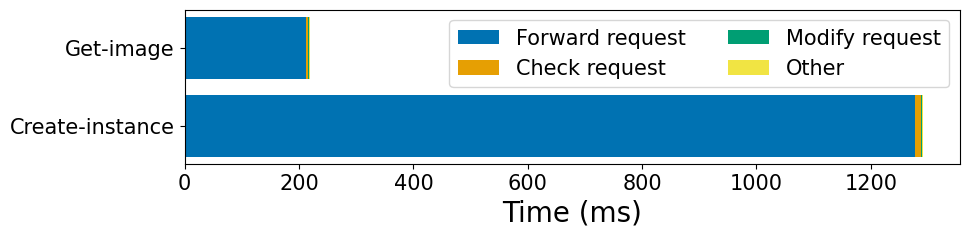

In [11]:
all = ['total', 'send_gcp_request', 'get_json_with_service_account', 'get_headers_with_auth', 'get_new_url', 'check_request_from_policy', 'check_request_from_policy-total', 'check_request_from_policy-check_request', 'check_request_from_policy-set_authorization_manager', 'check_request_from_policy-get_policy', 'check_request_from_policy-get_policy_managers', 'check_request_from_policy-setup_logs', 'verify_request_signature', 'setup_logs']

forward = []
check = []
modify = []
total = []

for k, d in post_times.items():
    forward.append(d['send_gcp_request'])
    check.append(d['check_request_from_policy-total'] + d['verify_request_signature'])
    modify.append(d['get_new_url'] + d['get_headers_with_auth'] + d['get_json_with_service_account'])
    total.append(d['total'] - forward[-1] - check[-1] - modify[-1])

print(len(forward))
print(len(check))
print(len(modify))
print(len(total))

#labels = [f"{i}" for i in range(1, len(forward) + 1)]
forwards = [np.mean(forward)]
checks = [np.mean(check)]
modifys = [np.mean(modify)]
totals = [np.mean(total)]

forward = []
check = []
modify = []
total = []

for k, d in get_times.items():
    forward.append(d['send_gcp_request'])
    check.append(d['check_request_from_policy-total'] + d['verify_request_signature'])
    modify.append(d['get_new_url'] + d['get_headers_with_auth'])
    total.append(d['total'] - forward[-1] - check[-1] - modify[-1])

print(len(forward))
print(len(check))
print(len(modify))
print(len(total))

labels = ['Create-instance', 'Get-image']
forwards.append(np.mean(forward))
checks.append(np.mean(check))
modifys.append(np.mean(modify))
totals.append(np.mean(total))

fig, ax = plt.subplots(figsize=(10, 2))
ax.barh(labels, forwards, label='Forward request', color=COLORS['blue'])
ax.barh(labels, checks, label='Check request', left=forwards, color=COLORS['orange'])
ax.barh(labels, modifys, label='Modify request', left=np.array(forwards) + np.array(checks), color=COLORS['green'])
ax.barh(labels, totals, label='Other', left=(np.array(forwards) + np.array(checks) + np.array(modifys)), color=COLORS['yellow'])

#ax.set_ylabel('Time (ms)')
ax.set_xlabel('Time (ms)')
#ax.set_title('POST request times')
#plt.yticks(rotation=90)

ax.legend(ncol=2)
plt.savefig("plots/breakdown-overall.pdf", format="pdf", bbox_inches="tight")

plt.show()
#plt.savefig("plots/post_overall_breakdown.png")

50


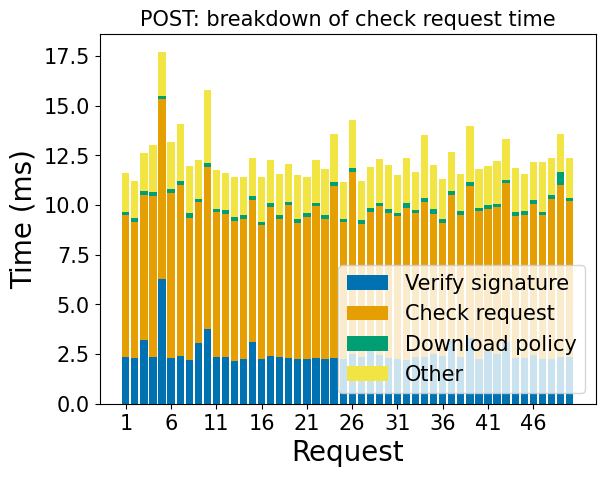

In [12]:
all = ['total', 'send_gcp_request', 'get_json_with_service_account', 'get_headers_with_auth', 'get_new_url', 'check_request_from_policy', 'check_request_from_policy-total', 'check_request_from_policy-check_request', 'check_request_from_policy-set_authorization_manager', 'check_request_from_policy-get_policy', 'check_request_from_policy-get_policy_managers', 'check_request_from_policy-setup_logs', 'verify_request_signature', 'setup_logs']

verify_sig = []
check_policy = []
get_policy = []
total_check = []

for k, d in post_times.items():
    verify_sig.append(d['verify_request_signature'])
    check_policy.append(d['check_request_from_policy-check_request'])
    get_policy.append(d['check_request_from_policy-get_policy'])
    total_check.append(d['check_request_from_policy-total'] + d['verify_request_signature'] - verify_sig[-1] - check[-1] - modify[-1])

print(len(verify_sig))

labels = [f"{i}" for i in range(1, len(forward) + 1)]

fig, ax = plt.subplots()
ax.bar(labels, verify_sig, label='Verify signature', color=COLORS['blue'])
ax.bar(labels, check_policy, label='Check request', bottom=verify_sig, color=COLORS['orange'])
ax.bar(labels, get_policy, label='Download policy', bottom=np.array(verify_sig) + np.array(check_policy), color=COLORS['green'])
ax.bar(labels, total, label='Other', bottom=np.array(verify_sig) + np.array(check_policy) + np.array(get_policy), color=COLORS['yellow'])

# Set x-ticks to every fifth label
ax.set_xticks(range(len(labels))[::5])
ax.set_xticklabels(labels[::5])

ax.set_ylabel('Time (ms)')
ax.set_xlabel('Request')
ax.set_title('POST: breakdown of check request time')

ax.legend(loc='lower right')
plt.show()
#plt.savefig("plots/post_check_breakdown.png")

defaultdict(<class 'list'>, {'POST937': {'total': 1254.3163299560547, 'send_gcp_request': 1240.6795024871826, 'get_json_with_service_account': 0.18310546875, 'get_headers_with_auth': 0.07939338684082031, 'get_new_url': 0.22268295288085938, 'check_request_from_policy': 8.765697479248047, 'check_request_from_policy-total': 8.587360382080078, 'check_request_from_policy-check_request': 7.1563720703125, 'check_request_from_policy-set_authorization_manager': 0.005245208740234375, 'check_request_from_policy-get_policy': 0.17642974853515625, 'check_request_from_policy-get_policy_managers': 0.004291534423828125, 'check_request_from_policy-setup_logs': 0.19979476928710938, 'verify_request_signature': 2.3393630981445312, 'setup_logs': 0.5323886871337891}, 'POST545': {'total': 1446.4478492736816, 'send_gcp_request': 1433.3138465881348, 'get_json_with_service_account': 0.1914501190185547, 'get_headers_with_auth': 0.06794929504394531, 'get_new_url': 0.2067089080810547, 'check_request_from_policy': 8

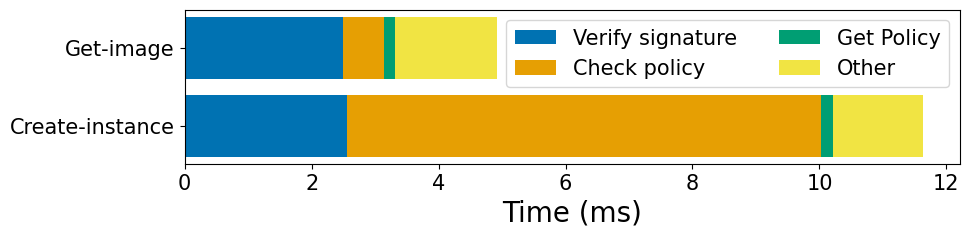

In [13]:
all = ['total', 'send_gcp_request', 'get_json_with_service_account', 'get_headers_with_auth', 'get_new_url', 'check_request_from_policy', 'check_request_from_policy-total', 'check_request_from_policy-check_request', 'check_request_from_policy-set_authorization_manager', 'check_request_from_policy-get_policy', 'check_request_from_policy-get_policy_managers', 'check_request_from_policy-setup_logs', 'verify_request_signature', 'setup_logs']

verify_sig = []
check_policy = []
get_policy = []
total_check = []

print(post_times)

for k, d in post_times.items():
    verify_sig.append(d['verify_request_signature'])
    check_policy.append(d['check_request_from_policy-check_request'])
    get_policy.append(d['check_request_from_policy-get_policy'])
    total_check.append(d['check_request_from_policy-total'] + d['verify_request_signature'] - verify_sig[-1] - check_policy[-1] - get_policy[-1])

#labels = [f"{i}" for i in range(1, len(forward) + 1)]
verify_sigs = [np.mean(verify_sig)]
check_policys = [np.mean(check_policy)]
get_policys = [np.mean(get_policy)]
total_checks = [np.mean(total_check)]

verify_sig = []
check_policy = []
get_policy = []
total_check = []

for k, d in get_times.items():
    verify_sig.append(d['verify_request_signature'])
    check_policy.append(d['check_request_from_policy-check_request'])
    get_policy.append(d['check_request_from_policy-get_policy'])
    total_check.append(d['check_request_from_policy-total'] + d['verify_request_signature'] - verify_sig[-1] - check_policy[-1] - get_policy[-1])

labels = ['Create-instance', 'Get-image']
verify_sigs.append(np.mean(verify_sig))
check_policys.append(np.mean(check_policy))
get_policys.append(np.mean(get_policy))
total_checks.append(np.mean(total_check))

fig, ax = plt.subplots(figsize=(10, 2))
ax.barh(labels, verify_sigs, label='Verify signature', color=COLORS['blue'])
ax.barh(labels, check_policys, label='Check policy', left=verify_sigs, color=COLORS['orange'])
ax.barh(labels, get_policys, label='Get Policy', left=np.array(verify_sigs) + np.array(check_policys), color=COLORS['green'])
ax.barh(labels, total_checks, label='Other', left=(np.array(verify_sigs) + np.array(check_policys) + np.array(get_policys)), color=COLORS['yellow'])

#ax.set_ylabel('Time (ms)')
ax.set_xlabel('Time (ms)')
#ax.set_title('POST request times')
#plt.yticks(rotation=90)

ax.legend(ncol=2)
plt.savefig("plots/check-breakdown.pdf", format="pdf", bbox_inches="tight")
plt.show()


50
50
50
50


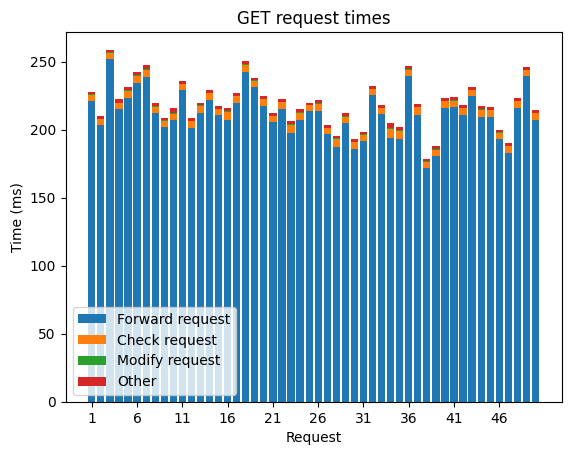

In [70]:
all = ['total', 'send_gcp_request', 'get_json_with_service_account', 'get_headers_with_auth', 'get_new_url', 'check_request_from_policy', 'check_request_from_policy-total', 'check_request_from_policy-check_request', 'check_request_from_policy-set_authorization_manager', 'check_request_from_policy-get_policy', 'check_request_from_policy-get_policy_managers', 'check_request_from_policy-setup_logs', 'verify_request_signature', 'setup_logs']

forward = []
check = []
modify = []
total = []

for k, d in get_times.items():
    forward.append(d['send_gcp_request'])
    check.append(d['check_request_from_policy-total'] + d['verify_request_signature'])
    modify.append(d['get_new_url'] + d['get_headers_with_auth'])
    total.append(d['total'] - forward[-1] - check[-1] - modify[-1])

print(len(forward))
print(len(check))
print(len(modify))
print(len(total))

labels = [f"{i}" for i in range(1, len(forward) + 1)]

fig, ax = plt.subplots()
ax.bar(labels, forward, label='Forward request')
ax.bar(labels, check, label='Check request', bottom=forward)
ax.bar(labels, modify, label='Modify request', bottom=np.array(forward) + np.array(check))
ax.bar(labels, total, label='Other', bottom=np.array(forward) + np.array(check) + np.array(modify))

# Set x-ticks to every fifth label
ax.set_xticks(range(len(labels))[::5])
ax.set_xticklabels(labels[::5])

ax.set_ylabel('Time (ms)')
ax.set_xlabel('Request')
ax.set_title('GET request times')

ax.legend()
plt.show()

#plt.savefig("plots/get_overall_breakdown.png")

50


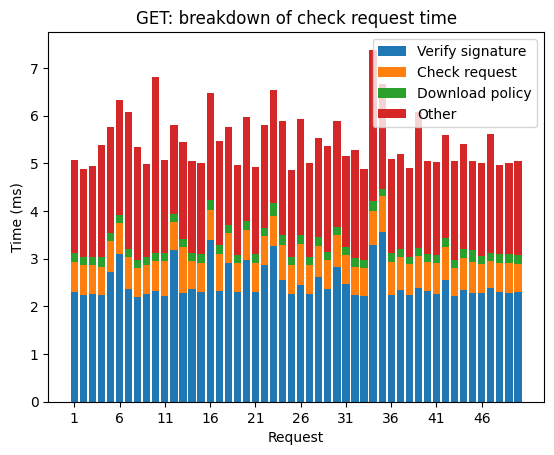

In [71]:
all = ['total', 'send_gcp_request', 'get_json_with_service_account', 'get_headers_with_auth', 'get_new_url', 'check_request_from_policy', 'check_request_from_policy-total', 'check_request_from_policy-check_request', 'check_request_from_policy-set_authorization_manager', 'check_request_from_policy-get_policy', 'check_request_from_policy-get_policy_managers', 'check_request_from_policy-setup_logs', 'verify_request_signature', 'setup_logs']

verify_sig = []
check_policy = []
get_policy = []
total_check = []

for k, d in get_times.items():
    verify_sig.append(d['verify_request_signature'])
    check_policy.append(d['check_request_from_policy-check_request'])
    get_policy.append(d['check_request_from_policy-get_policy'])
    total_check.append(d['check_request_from_policy-total'] + d['verify_request_signature'] - verify_sig[-1] - check[-1] - modify[-1])

print(len(verify_sig))

labels = [f"{i}" for i in range(1, len(verify_sig) + 1)]

fig, ax = plt.subplots()
ax.bar(labels, verify_sig, label='Verify signature')
ax.bar(labels, check_policy, label='Check request', bottom=verify_sig)
ax.bar(labels, get_policy, label='Download policy', bottom=np.array(verify_sig) + np.array(check_policy))
ax.bar(labels, total, label='Other', bottom=np.array(verify_sig) + np.array(check_policy) + np.array(get_policy))

# Set x-ticks to every fifth label
ax.set_xticks(range(len(labels))[::5])
ax.set_xticklabels(labels[::5])

ax.set_ylabel('Time (ms)')
ax.set_xlabel('Request')
ax.set_title('GET: breakdown of check request time')

ax.legend()
plt.show()
#plt.savefig("plots/get_check_breakdown.png")

In [15]:
def process_rt(n, batch=None, skydentity=True):
    get_image_times = []
    create_instance_times = []
    for i in range(n):
        if batch:
            batch_str = f"_{batch}"
        else:
            batch_str = ""
        if skydentity:
            fname = f"logs/with_skydentity{batch_str}/stdout_{i}.txt"
        else:
            fname = f"logs/baseline{batch_str}/stdout_{i}.txt"
        with builtins.open(fname, 'r') as f:
            lines = f.readlines()
            for line in lines:
                if "Time to get image" in line:
                    get_image_times.append(float(line.split(" ")[-1]))
                elif "Time for instance creation req" in line:
                    create_instance_times.append(float(line.split(" ")[-1]))
    return (get_image_times, create_instance_times)

def plot_rts(n_requests, batch=None):
    get_image_times, create_instance_times = process_rt(n_requests, batch=batch)
    get_image_skydentity = np.array(get_image_times)
    print(np.mean(get_image_skydentity[1:]), np.std(get_image_skydentity[1:]))
    create_instance_skydentity = np.array(create_instance_times)
    plt.bar(range(n_requests), get_image_times)
    if batch:
        plt.title(f"Get image times (CloudGate, {batch} concurrent reqs)")
    else:
        plt.title("Get image times (CloudGate)")
    plt.xlabel("Request")
    plt.ylabel("Time (s)")
    plt.show()

    plt.bar(range(n_requests), create_instance_times)
    if batch:
        plt.title(f"Create instance times (CloudGate, {batch} concurrent reqs)")
    else:
        plt.title("Create instance times (CloudGate)")
    plt.xlabel("Request")
    plt.ylabel("Time (s)")
    plt.show()

    get_image_times, create_instance_times = process_rt(n_requests, batch=batch, skydentity=False)
    get_image_baseline = np.array(get_image_times)
    print(np.mean(get_image_baseline), np.std(get_image_baseline))
    create_instance_baseline = np.array(create_instance_times)
    plt.bar(range(n_requests), get_image_times)
    if batch:
        plt.title(f"Get image times (Baseline, {batch} concurrent reqs)")
    else:
        plt.title("Get image times (Baseline)")
    plt.xlabel("Request")
    plt.ylabel("Time (s)")
    plt.show()

    plt.bar(range(n_requests), create_instance_times)
    plt.bar(range(n_requests), create_instance_times)
    if batch:
        plt.title(f"Create instance times (Baseline, {batch} concurrent reqs)")
    else:
        plt.title("Create instance times (Baseline)")
    plt.xlabel("Request")
    plt.ylabel("Time (s)")
    plt.show()

    print(f"Get image times: Skydentity | Mean: {np.mean(get_image_skydentity[1:])} s, Std Dev: {np.std(get_image_skydentity[1:])} s | Median: {np.median(get_image_skydentity)} s | Max: {np.max(get_image_skydentity)} s | Min: {np.min(get_image_skydentity)} s")
    print(f"Create instance times: Skydentity | Mean: {np.mean(create_instance_skydentity)} s, Std Dev: {np.std(create_instance_skydentity)} s | Median: {np.median(create_instance_skydentity)} s | Max: {np.max(create_instance_skydentity)} s | Min: {np.min(create_instance_skydentity)} s")
    print(f"Get image times: Baseline | Mean: {np.mean(get_image_baseline)} s, Std Dev: {np.std(get_image_baseline)} s | Median: {np.median(get_image_baseline)} s | Max: {np.max(get_image_baseline)} s | Min: {np.min(get_image_baseline)} s")
    print(f"Create instance times: Baseline | Mean: {np.mean(create_instance_baseline)} s, Std Dev: {np.std(create_instance_baseline)} s | Median: {np.median(create_instance_baseline)} s | Max: {np.max(create_instance_baseline)} s | Min: {np.min(create_instance_baseline)} s")

0.4156680107116699 0.067073917211522


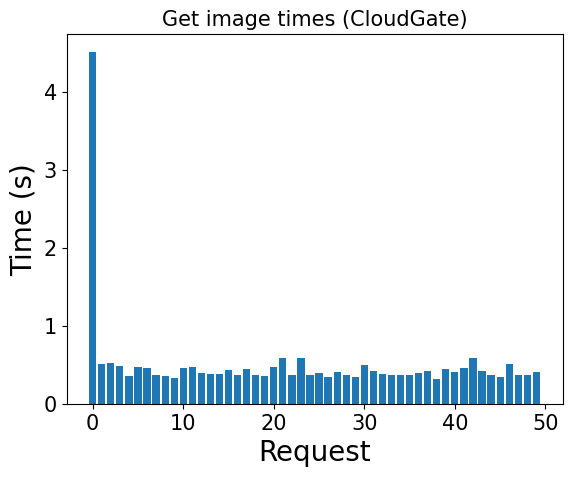

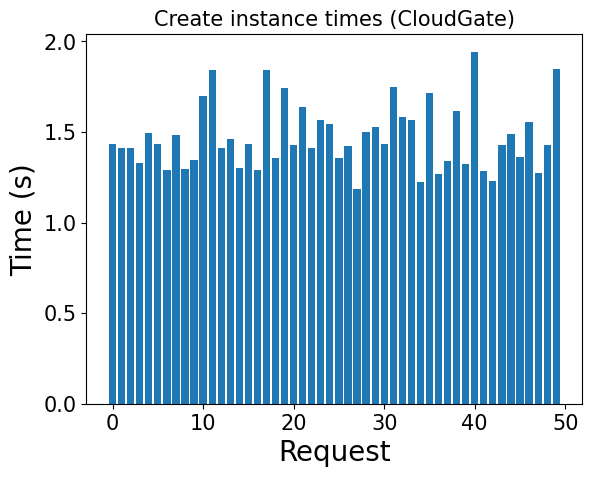

0.3180195760726929 0.05738355462316978


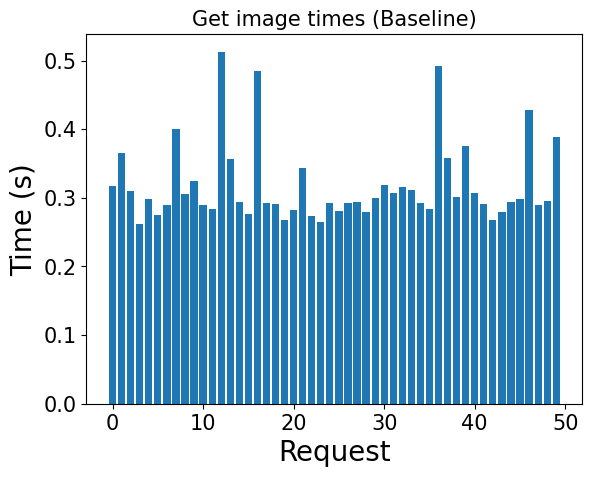

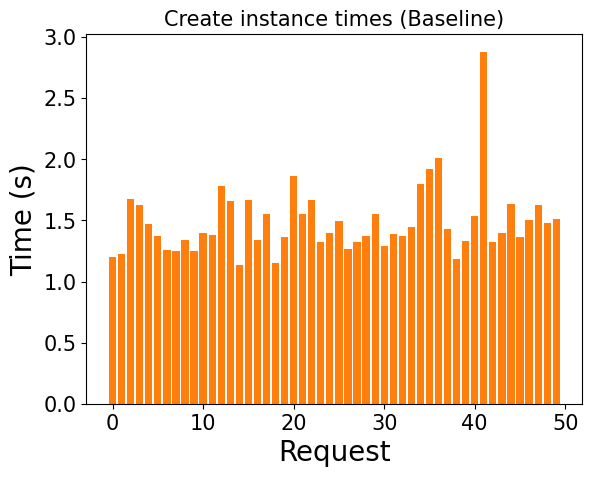

Get image times: Skydentity | Mean: 0.4156680107116699 s, Std Dev: 0.067073917211522 s | Median: 0.39611899852752686 s | Max: 4.519573926925659 s | Min: 0.31818103790283203 s
Create instance times: Skydentity | Mean: 1.4706159918289632 s, Std Dev: 0.17744970255868683 s | Median: 1.4303952528862283 s | Max: 1.94248016201891 s | Min: 1.1872588370461017 s
Get image times: Baseline | Mean: 0.3180195760726929 s, Std Dev: 0.05738355462316978 s | Median: 0.29462170600891113 s | Max: 0.5130107402801514 s | Min: 0.2626309394836426 s
Create instance times: Baseline | Mean: 1.4866489420877769 s, Std Dev: 0.28028332608673556 s | Median: 1.3992880283622071 s | Max: 2.8802546178922057 s | Min: 1.13328804099001 s


In [198]:
plot_rts(50)

1.3377302137471863 3.118676240183373


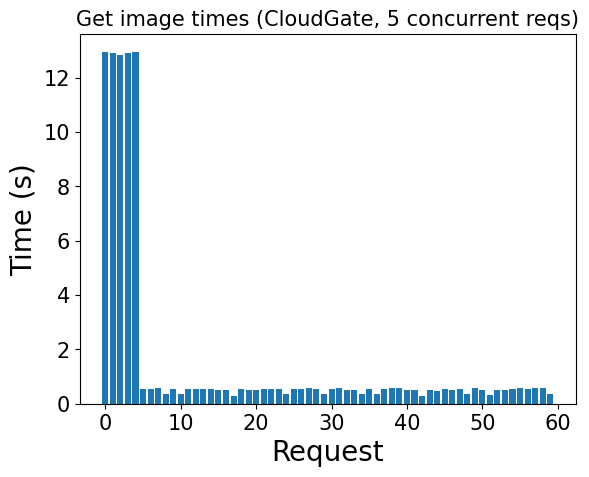

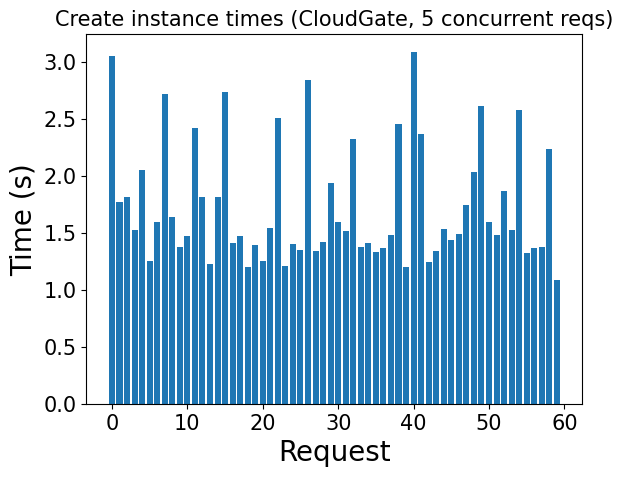

0.5102710247039794 0.10359192756426244


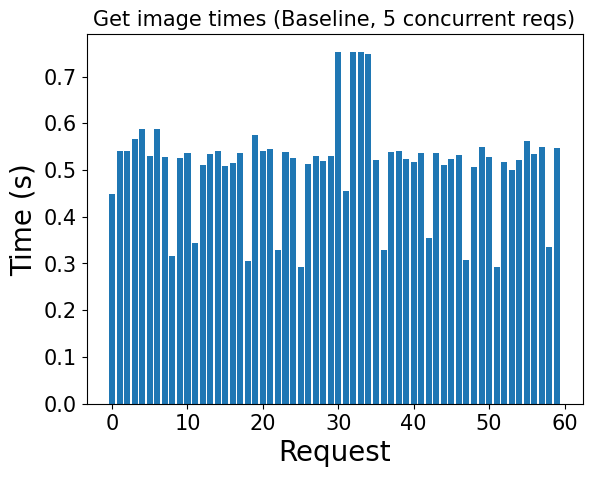

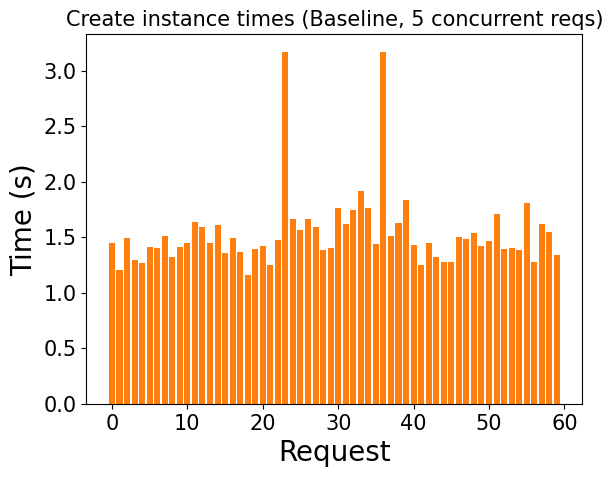

Get image times: Skydentity | Mean: 1.5313035289446513 s, Std Dev: 3.431443749493099 s | Median: 0.5332846641540527 s | Max: 12.952129125595093 s | Min: 0.29973578453063965 s
Create instance times: Skydentity | Mean: 1.7305664752998078 s, Std Dev: 0.5160048669677323 s | Median: 1.5178185104159638 s | Max: 3.0872938248794526 s | Min: 1.088360799010843 s
Get image times: Baseline | Mean: 0.5102710247039794 s, Std Dev: 0.10359192756426244 s | Median: 0.5290570259094238 s | Max: 0.753040075302124 s | Min: 0.2918217182159424 s
Create instance times: Baseline | Mean: 1.534990543150343 s, Std Dev: 0.3441747203466688 s | Median: 1.4489670494804159 s | Max: 3.1691221660003066 s | Min: 1.1614134958945215 s


In [129]:
# Cold start
plot_rts(60, batch=5)

0.8779746112176927 0.31867939283176766


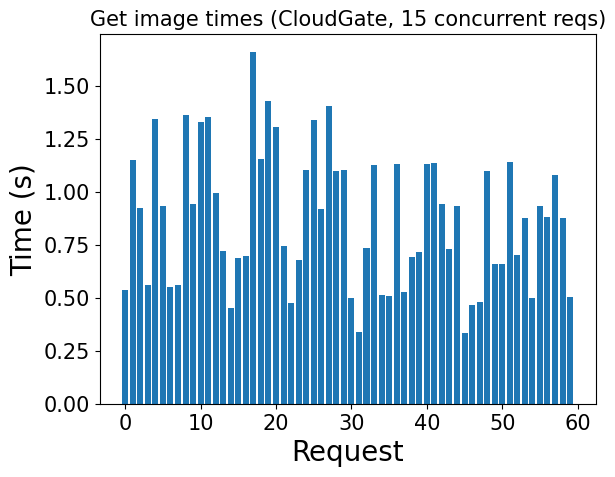

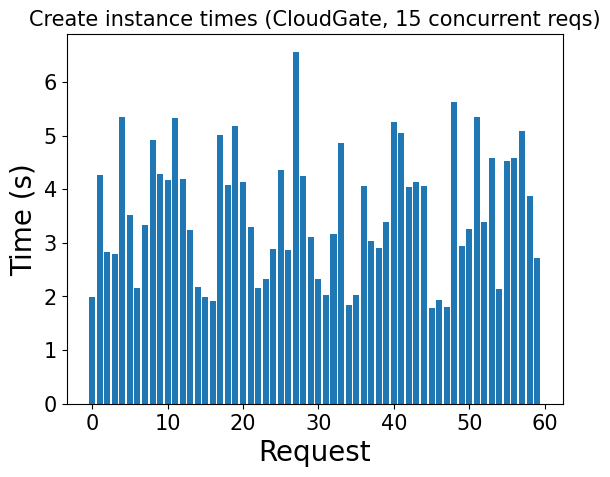

0.5341122666994731 0.07394467386302017


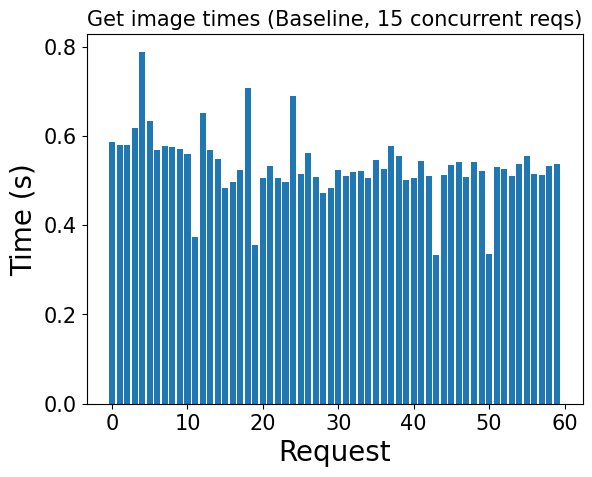

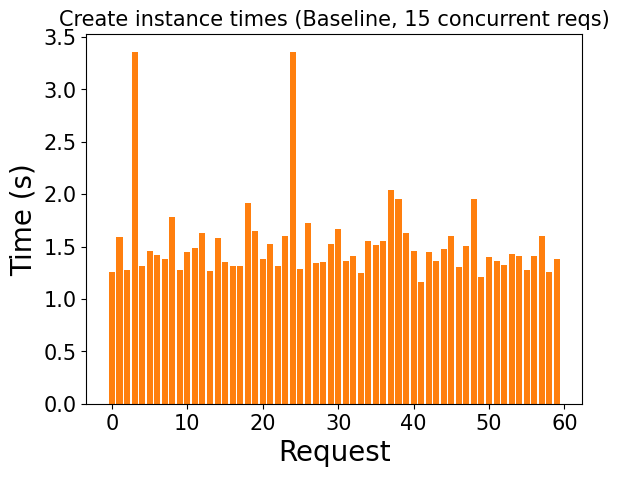

Get image times: Skydentity | Mean: 0.8722866177558899 s, Std Dev: 0.3190184776253034 s | Median: 0.8787134885787964 s | Max: 1.6605908870697021 s | Min: 0.33189916610717773 s
Create instance times: Skydentity | Mean: 3.574063803515552 s, Std Dev: 1.1949463800975308 s | Median: 3.3903807010501623 s | Max: 6.5641267341561615 s | Min: 1.7871715289074928 s
Get image times: Baseline | Mean: 0.5341122666994731 s, Std Dev: 0.07394467386302017 s | Median: 0.528038501739502 s | Max: 0.7887639999389648 s | Min: 0.3323640823364258 s
Create instance times: Baseline | Mean: 1.5288318930154976 s, Std Dev: 0.3888592970424637 s | Median: 1.4216471780091524 s | Max: 3.3601579391397536 s | Min: 1.166589786997065 s


In [130]:
# Cold start
plot_rts(60, batch=15)


In [177]:
get_times_with_cache_policy, create_times_with_cache_policy = process_rt(60, batch=1)
get_times_with_cache_policy = np.array(get_times_with_cache_policy)
create_instance_skydentity = np.array(create_times_with_cache_policy)
print(f"Get image times: Skydentity | Mean: {np.mean(get_times_with_cache_policy)} ms, Std Dev: {np.std(get_times_with_cache_policy)} ms | Median: {np.median(get_times_with_cache_policy)} ms | Max: {np.max(get_times_with_cache_policy)} ms | Min: {np.min(get_times_with_cache_policy)} ms")
print(f"Create instance times: Skydentity | Mean: {np.mean(create_times_with_cache_policy)} ms, Std Dev: {np.std(create_times_with_cache_policy)} ms | Median: {np.median(create_times_with_cache_policy)} ms | Max: {np.max(create_times_with_cache_policy)} ms | Min: {np.min(create_times_with_cache_policy)} ms")

Get image times: Skydentity | Mean: 0.4294004956881205 ms, Std Dev: 0.08603159826491726 ms | Median: 0.40239953994750977 ms | Max: 0.7320132255554199 ms | Min: 0.3201150894165039 ms
Create instance times: Skydentity | Mean: 1.5135038593551144 ms, Std Dev: 0.16601093803106393 ms | Median: 1.5425747155677527 ms | Max: 1.8354713539592922 ms | Min: 1.1258559320122004 ms


[2.3434708239510655, 1.7064184464979917, 1.7604517133440822, 1.8189890345092863, 1.4742569990921766, 1.6265883832238615, 1.8201806813012809, 1.351771898334846, 1.5379152016248554, 1.7014625621959567, 1.7318734761793166, 1.7324876380153, 1.8203499987721443, 1.7154141780920327, 1.7273105811327696, 1.8254650295712054, 1.5920944367535412, 1.8340418036095798, 1.505417256616056, 1.6077178858686239, 1.789234438445419, 2.0400413097813725, 1.607326040044427, 1.62112818332389, 1.7823845418170094, 1.8714823885820806, 1.8153172836173326, 2.0025147104170173, 1.6333665947895497, 1.528470512945205, 1.7361184090841562, 1.669689578237012, 1.722531726816669, 1.524962856899947, 1.9032107079401612, 1.5757860688026994, 1.7850181094836444, 1.7287141126580536, 1.6924882547464222, 1.8102355466689914, 2.1603385892231017, 1.8094374388456345, 2.1956642349250615, 1.8602780024521053, 1.6663217856548727, 1.7898488298524171, 1.7193402007687837, 1.6868296810425818, 1.6644861449021846, 1.880430129589513, 1.68198087112

/var/folders/3z/lm1_8z3s2sx55436y5sss0bh0000gp/T/ipykernel_12576/1454390494.py:64: FutureWarning: The provided callable <function mean at 0x113f2f9a0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  df_pivot_get_img = pd.pivot_table(


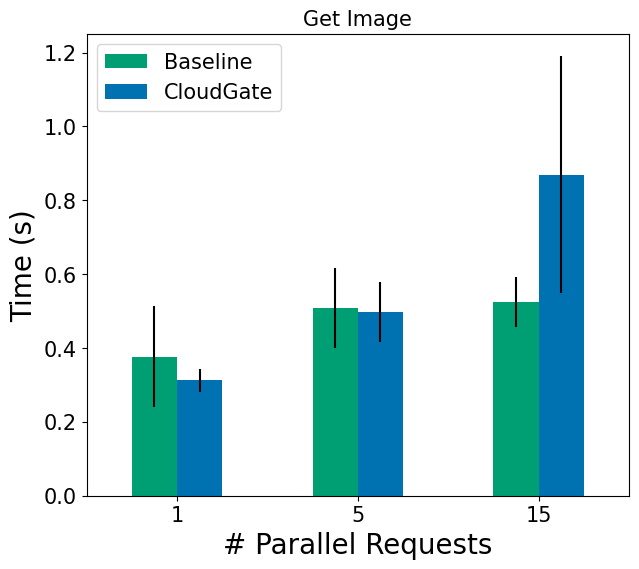

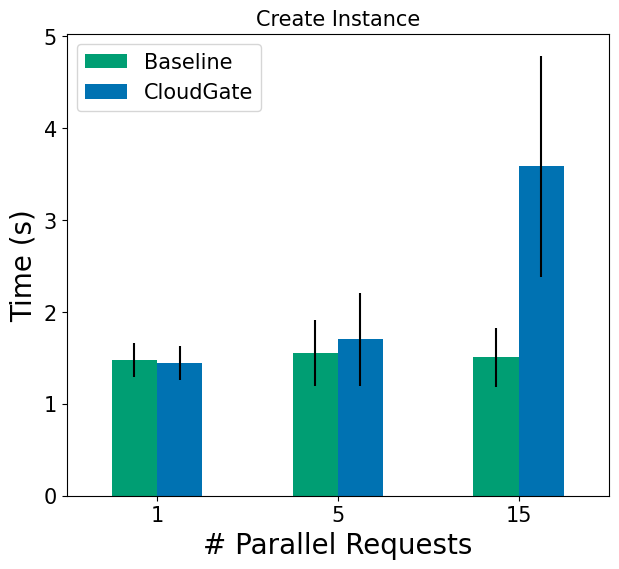

In [20]:
from itertools import cycle, islice

batch_sizes = [1, 5, 15]
gbs = []
cbs = []
gs = []
cs = []
batch_size_array = []

for batch in batch_sizes:
    g, c = process_rt(60, batch=batch)
    g = g[5:]
    c = c[5:]
    for t in g:
        batch_size_array.append(batch)
        gs.append(t)
    for t in c:
        cs.append(t)
for batch in batch_sizes:
    gb, cb = process_rt(60, batch=batch, skydentity=False)
    gb = gb[5:]
    cb = cb[5:]
    for t in gb:
        batch_size_array.append(batch)
        gbs.append(t)
    for t in cb:
        cbs.append(t)

import pandas as pd
columns = ['batch_size', 'get_image_time', 'create_instance_time', 'cloudgate']
df_dict = {
    columns[0]: batch_size_array,
    columns[1]: gs + gbs,
    columns[2]: cs + cbs,
    columns[3]: ['CloudGate'] * 55 * len(batch_sizes) + ['Baseline'] * 55 * len(batch_sizes) 
}

columns_overall = ['batch_size', 'latency', 'cloudgate']
print([gs[i] + cs[i] for i in range(len(gs))])
df_dict_overall = {
    columns_overall[0]: batch_size_array,
    columns_overall[1]: [gs[i] + cs[i] for i in range(len(gs))] + [gbs[i] + cbs[i] for i in range(len(gbs))],
    columns_overall[2]: ['CloudGate'] * 55 * len(batch_sizes) + ['Baseline'] * 55 * len(batch_sizes) 
}
df_overall = pd.DataFrame(df_dict_overall, columns=columns_overall)
df_overall_pivot = pd.pivot_table(
    df_overall,
    values="latency",
    index="batch_size",
    columns="cloudgate",
    aggfunc='mean'
)
yerr_overall_pivot = pd.pivot_table(
    df_overall,
    values="latency",
    index="batch_size",
    columns="cloudgate",
    aggfunc='std'
)
print(df_overall_pivot)

df = pd.DataFrame(df_dict, columns=columns)

df_pivot_get_img = pd.pivot_table(
	df,
	values="get_image_time",
	index="batch_size",
	columns="cloudgate",
	aggfunc=np.mean
)

yerr_pivot_get_img = pd.pivot_table(
	df,
	values="get_image_time",
	index="batch_size",
	columns="cloudgate",
	aggfunc='std'
)

#print(df_pivot)

# Plot a bar chart using the DF
ax = df_pivot_get_img.plot(kind="bar", yerr=yerr_pivot_get_img, color=COLORS.values())
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xticklabels([1, 5, 15], rotation=0)
ax.set_title("Get Image")
ax.set_xlabel("# Parallel Requests")
ax.set_ylabel("Time (s)")
ax.legend(loc='upper left')

# Use this to show the plot in a new window
plt.savefig("plots/get_image_n_parallel.pdf", format="pdf", bbox_inches="tight")

plt.show()
# Export the plot as a PNG file
#fig.savefig("page_views_barplot.png")
df_pivot_create_inst = pd.pivot_table(
	df,
	values="create_instance_time",
	index="batch_size",
	columns="cloudgate",
	aggfunc='mean'
)

yerr_pivot_create_inst = pd.pivot_table(
	df,
	values="create_instance_time",
	index="batch_size",
	columns="cloudgate",
	aggfunc='std'
)

# Plot a bar chart using the DF
ax = df_pivot_create_inst.plot(kind="bar", yerr=yerr_pivot_create_inst, color=COLORS.values())
# Get a Matplotlib figure from the axes object for formatting purposes
fig = ax.get_figure()
# Change the plot dimensions (width, height)
fig.set_size_inches(7, 6)
# Change the axes labels
ax.set_xticklabels([1, 5, 15], rotation=0)
ax.set_title("Create Instance")
ax.set_xlabel("# Parallel Requests")
ax.set_ylabel("Time (s)")
ax.legend(loc='upper left')

# Use this to show the plot in a new window
plt.savefig("plots/create_instance_n_parallel.pdf", format="pdf", bbox_inches="tight")
plt.show()


In [248]:
# Create authorization data
upload_auth_policy = [1.022, 1.533, 1.609, 1.040, 1.017]
send_auth_request = [4.149, 4.438, 4.132, 4.832, 3.785]
upload_resource_policy = [1.203, 1.018, 1.022, 1.145, 1.086]
total_setup = [upload_auth_policy[i] + send_auth_request[i] + upload_resource_policy[i] for i in range(len(upload_auth_policy))]
print(f"Upload auth policy | Mean: {np.mean(upload_auth_policy)} s, Std Dev: {np.std(upload_auth_policy)} s")
print(f"Send auth request | Mean: {np.mean(send_auth_request)} s, Std Dev: {np.std(send_auth_request)} s")
print(f"Upload resource policy | Mean: {np.mean(upload_resource_policy)} s, Std Dev: {np.std(upload_resource_policy)} s")
print(f"Total setup | Mean: {np.mean(total_setup)} s, Std Dev: {np.std(total_setup)} s")

Upload auth policy | Mean: 1.2442 s, Std Dev: 0.2680204469811958 s
Send auth request | Mean: 4.2672 s, Std Dev: 0.3501253489823322 s
Upload resource policy | Mean: 1.0948 s, Std Dev: 0.07141820496204034 s
Total setup | Mean: 6.606199999999999 s, Std Dev: 0.4265224026941608 s


In [22]:
# Throughput
import re
batch_str = '\d+ of \d+ in batch \d+'

with builtins.open("logs/batch_times_vary_batch_size_cache_private_key.txt", 'r') as f:
    lines = f.readlines()
    batch_times = defaultdict(list)
    total_times = defaultdict(list)
    batch_size = 0
    n_batches = 0
    for line in lines:
        if re.search(batch_str, line):
            batch_size = float(line.split(" ")[5])
            if "1 of" in line:
                n_batches = int(line.split(" ")[-1].split(")")[0]) + 1
        elif "BATCH TIME (s)" in line:
            batch_times[batch_size].append(float(line.split(" ")[-1]))
        elif "TOTAL TIME" in line:
            total_times[batch_size].append(float(line.split(" ")[-1]))
    batch_times[5] = batch_times[5][1:]
    print(f"Batch times: {batch_times}")
    print(f"Total times: {total_times}")

with builtins.open("logs/baseline_times_vary_batch_size_cache_private_key.txt", 'r') as f:
    lines = f.readlines()
    batch_times_baseline = defaultdict(list)
    total_times_baseline = defaultdict(list)
    batch_size = 0
    n_batches = 0
    for line in lines:
        if re.search(batch_str, line):
            batch_size = float(line.split(" ")[5])
            if "1 of" in line:
                n_batches = int(line.split(" ")[-1].split(")")[0]) + 1
        elif "BATCH TIME (s)" in line:
            batch_times_baseline[batch_size].append(float(line.split(" ")[-1]))
        elif "TOTAL TIME" in line:
            total_times_baseline[batch_size].append(float(line.split(" ")[-1]))
    print(f"Batch times: {batch_times_baseline}")
    print(f"Total times: {total_times_baseline}")

Batch times: defaultdict(<class 'list'>, {5.0: [4.404990201117471, 4.092677146894857, 4.344506516121328, 4.149014143040404, 4.51964166900143, 3.935056325979531, 4.144363676896319, 4.706233674893156, 4.2777001010254025, 4.187349523883313, 3.8446542299352586], 15.0: [8.731522256042808, 9.864821519935504, 8.270836099982262, 8.65028699603863], 1.0: [2.8367145811207592, 2.855779241072014, 2.5575341479852796, 2.740375684108585, 2.691871645161882, 3.27638624003157, 2.6541519979946315, 2.7052360330708325, 2.7744554919190705, 2.406021221075207, 2.5664477520622313, 2.7664664348121732, 2.2873366097919643, 2.525411341106519, 2.6369213829748333, 2.6689797448925674, 2.690954366000369, 2.7578326838556677, 2.6535886770579964, 2.674921807833016, 2.769048417918384, 2.537262379191816, 2.7900613981764764, 2.454327106010169, 2.5622567869722843, 2.7286776851397008, 2.9968085838481784, 2.546969720860943, 2.5566519980784506, 2.727011001901701, 2.809228557161987, 2.76777503779158, 2.944789089029655, 2.57188043

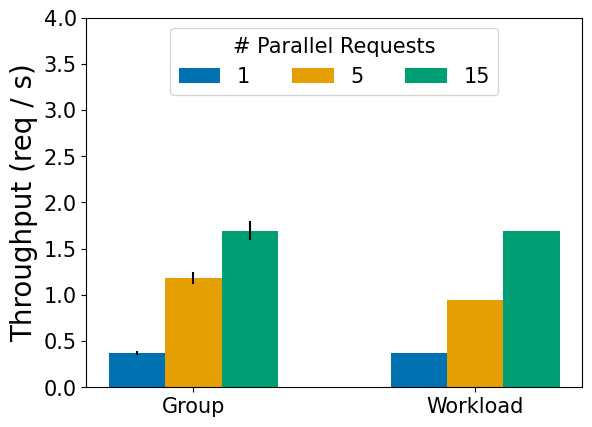

In [23]:
import numpy as np
import matplotlib.pyplot as plt
# create data for latency graph
x_data = np.arange(2)
batch_sizes = list(batch_times.keys())
y_1 = [np.mean(1/np.array(batch_times[1])), 60 / total_times[1][0]]
y_1_err = [np.std(1/np.array(batch_times[1])), 0]
y_5 = [np.mean(5/np.array(batch_times[5])), 60 / total_times[5][0]]
y_5_err = [np.std(5/np.array(batch_times[5])), 0]
y_15 = [np.mean(15/np.array(batch_times[15])), 60 / total_times[15][0]]
y_15_err = [np.std(15/np.array(batch_times[15])), 0]
width = 0.2
  
# plot grouped bar chart 
plt.bar(x_data - width, y_1, width, yerr=y_1_err, color=COLORS['blue']) 
plt.bar(x_data, y_5, width, yerr=y_5_err, color=COLORS['orange']) 
plt.bar(x_data + width, y_15, width, yerr=y_15_err, color=COLORS['green']) 
plt.xticks(x_data, ['Group', 'Workload']) 
plt.ylabel("Throughput (req / s)") 
plt.ylim(0, 4)
plt.legend(['1', '5', '15'], loc='upper center', title="# Parallel Requests", ncols=3) 
plt.savefig("plots/throughput_n_parallel.pdf", format="pdf", bbox_inches="tight")
plt.show() 


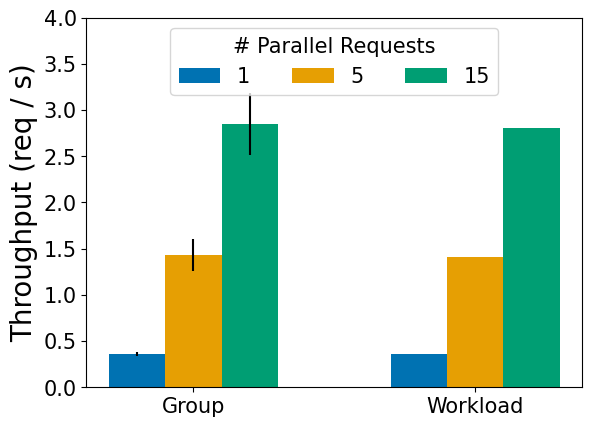

In [24]:
import numpy as np
import matplotlib.pyplot as plt
# create data for latency graph
x_data = np.arange(2)
batch_sizes = list(batch_times_baseline.keys())
y_1 = [np.mean(1/np.array(batch_times_baseline[1])), 60 / total_times_baseline[1][0]]
y_1_err = [np.std(1/np.array(batch_times_baseline[1])), 0]
y_5 = [np.mean(5/np.array(batch_times_baseline[5])), 60 / total_times_baseline[5][0]]
y_5_err = [np.std(5/np.array(batch_times_baseline[5])), 0]
y_15 = [np.mean(15/np.array(batch_times_baseline[15])), 60 / total_times_baseline[15][0]]
y_15_err = [np.std(15/np.array(batch_times_baseline[15])), 0]
width = 0.2
  
# plot grouped bar chart 
plt.bar(x_data - width, y_1, width, yerr=y_1_err, color=COLORS['blue']) 
plt.bar(x_data, y_5, width, yerr=y_5_err, color=COLORS['orange']) 
plt.bar(x_data + width, y_15, width, yerr=y_15_err, color=COLORS['green']) 
plt.xticks(x_data, ['Group', 'Workload']) 
plt.ylabel("Throughput (req / s)") 
plt.ylim(0, 4)
plt.legend(['1', '5', '15'], loc='upper center', title="# Parallel Requests", ncols=3) 
plt.savefig("plots/throughput_n_parallel_baseline.pdf", format="pdf", bbox_inches="tight")
plt.show() 


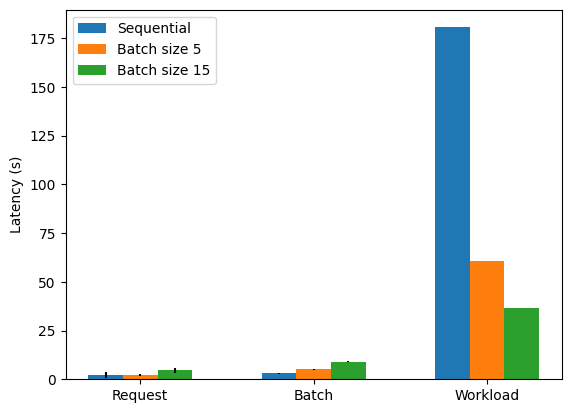

In [114]:
import numpy as np
import matplotlib.pyplot as plt
# create data for throughput graph
x_data = np.arange(3)
batch_sizes = list(batch_times.keys())
y_data = []
y_errs = []
for batch_size in sorted(batch_sizes):
    y = [df_overall_pivot['CloudGate'][batch_size], 
         np.mean(np.array(batch_times[batch_size])), total_times[batch_size][0]]
    y_err = [yerr_overall_pivot['CloudGate'][batch_size], np.std(np.array(batch_times[1])), 0] 
    y_data.append(y)
    y_errs.append(y_err)
width = 0.2
  
# plot grouped bar chart 
plt.bar(x_data - width, y_data[0], width, yerr=y_errs[0]) 
plt.bar(x_data, y_data[1], width, yerr=y_errs[1]) 
plt.bar(x_data + width, y_data[2], width, yerr=y_errs[2]) 
plt.xticks(x_data, ['Request', 'Batch', 'Workload']) 
plt.ylabel("Latency (s)") 
plt.legend(['Sequential', 'Batch size 5', 'Batch size 15'], loc='upper left') 
plt.show() 

In [314]:
df_overall_pivot

cloudgate
batch_size


In [304]:
yerr_pivot_create_inst

cloudgate,Baseline,CloudGate
batch_size,,
1,0.370174,0.182828
5,0.331320,0.624274
15,0.171940,1.312913


In [14]:
import datetime
import builtins
timestamps = []
for i in range(50, 60):
    with builtins.open(f"logs/with_skydentity_15/stdout_{i}.txt") as f:
        lines = f.readlines()
        timestamps.append(datetime.datetime.strptime(lines[1].split(" ")[-1].strip(), "%H:%M:%S.%f"))
timestamps = sorted(timestamps)
print([datetime.datetime.strftime(t, "%H:%M:%S.%f") for t in timestamps])

['18:48:52.028163', '18:48:52.517637', '18:48:52.524276', '18:48:52.733994', '18:48:52.776100', '18:48:52.971451', '18:48:52.986739', '18:48:52.990773', '18:48:52.999523', '18:48:53.196880']


In [131]:
import numpy as np
compare_timestamps = []
with builtins.open("../../gcp-server-proxy/redirector.log", 'r') as f:
    pattern = "POST /compute/v1/projects/sky-identity/zones/us-west1-b/instances: 2024-04-09 18:48"
    lines = f.readlines()
    for line in lines:
        if pattern in line:
            compare_timestamps.append(datetime.datetime.strptime(line.split(" ")[-1].strip(), "%H:%M:%S.%f"))
compare_timestamps = compare_timestamps[-10:]
print("Logged in redirector:", [datetime.datetime.strftime(t, "%H:%M:%S.%f") for t in compare_timestamps])
print("Logged in application:", [datetime.datetime.strftime(t, "%H:%M:%S.%f") for t in timestamps])
diffs = []
for i in range(len(compare_timestamps)):
    diffs.append((compare_timestamps[i] - timestamps[i]).total_seconds())
print("Average seconds from sending request from Python client to reaching redirector handler (one request at a time): ", np.mean(np.array(diffs)), np.std(np.array(diffs)))

Logged in redirector: ['18:48:52.529310', '18:48:52.731236', '18:48:52.740311', '18:48:52.780713', '18:48:52.976528', '18:48:52.991703', '18:48:52.995846', '18:48:53.005736', '18:48:53.202485', '18:48:53.211741']
Logged in application: ['18:48:52.028163', '18:48:52.517637', '18:48:52.524276', '18:48:52.733994', '18:48:52.776100', '18:48:52.971451', '18:48:52.986739', '18:48:52.990773', '18:48:52.999523', '18:48:53.196880']
Average seconds from sending request from Python client to reaching redirector handler (one request at a time):  0.1440073 0.14850871635500051


In [134]:
with builtins.open("logs/redirector_log.txt", "r") as f:
    lines = f.readlines()
    handler_times = []
    for line in lines:
        if "through modify_json" in line:
            handler_times.append(float(line.split(" ")[-1].split('s')[0]))
print("Handler times:", handler_times)
print(np.mean(handler_times), np.std(handler_times))

Handler times: [0.01, 0.03, 0.04, 0.04, 0.04, 0.05, 0.01, 0.01, 0.01, 0.01, 0.0, 0.04, 0.03, 0.04, 0.04, 0.04, 0.01, 0.03, 0.02, 0.03, 0.01, 0.04, 0.04, 0.04, 0.05, 0.05, 0.01, 0.01, 0.02, 0.02, 0.01, 0.04, 0.04, 0.05, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.0, 0.04, 0.05, 0.05, 0.05, 0.05, 0.01, 0.01, 0.01, 0.01, 0.01, 0.04, 0.04, 0.04, 0.04, 0.04, 0.01, 0.03, 0.04, 0.04, 0.04, 0.03, 0.05, 0.04, 0.04, 0.04, 0.0, 0.01, 0.02, 0.0, 0.0, 0.04, 0.04, 0.05, 0.04, 0.04, 0.01, 0.01, 0.02, 0.02, 0.02, 0.03, 0.04, 0.05, 0.04, 0.05, 0.01, 0.01, 0.01, 0.01, 0.0, 0.04, 0.04, 0.04, 0.04, 0.05, 0.01, 0.01, 0.01, 0.01, 0.0, 0.03, 0.04, 0.05, 0.05, 0.05, 0.01, 0.01, 0.02, 0.02, 0.0, 0.03, 0.04, 0.04, 0.05, 0.05, 0.01, 0.01, 0.0, 0.01, 0.01]
0.02727272727272727 0.016910068397943886
